In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-01-26 19:41:28--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.001s  

2021-01-26 19:41:28 (16.5 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30       9/8/2016   
1           2             2     PAIDOFF       1000     30       9/8/2016   
2           3             3     PAIDOFF       1000     15       9/8/2016   
3           4             4     PAIDOFF       1000     30       9/9/2016   
4           6             6     PAIDOFF       1000     30       9/9/2016   

    due_date  age             education  Gender  
0  10/7/2016   45  High School or Below    male  
1  10/7/2016   33              Bechalor  female  
2  9/22/2016   27               college    male  
3  10/8/2016   28               college  female  
4  10/8/2016   29               college    male

In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  
0 2016-10-07   45  High School or Below    male  
1 2016-10-07   33              Bechalor  female  
2 2016-09-22   27               college    male  
3 2016-10-08   28               college  female  
4 2016-10-08   29               college    male

# Data visualization and pre-processing



In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [7]:
!conda install -c anaconda seaborn -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    argon2-cffi-20.1.0         |   py37h7b6447c_1          49 KB  anaconda
    defusedxml-0.6.0           |             py_0          23 KB  anaconda
    entrypoints-0.3            |           py37_0          12 KB  anaconda
    fontconfig-2.13.0          |       h9420a91_0         291 KB  anaconda
    icu-58.2                   |       he6710b0_3        22.7 MB  anaconda
    jupyter_client-6.1.7       |             py_0         

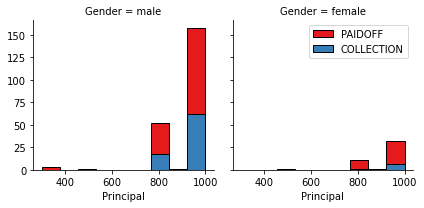

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

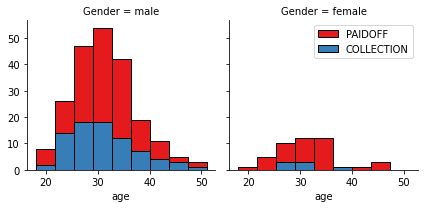

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

### Lets look at the day of the week people get the loan 

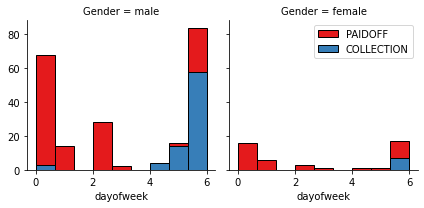

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  dayofweek  weekend  
0 2016-10-07   45  High School or Below    male          3        0  
1 2016-10-07   33              Bechalor  female          3        0  
2 2016-09-22   27               college    male          3        0  
3 2016-10-08   28               college  female          4        1  
4 2016-10-08   29               college    male          4        1

## Categorical to numerical vals

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

Male = 0 & Female = 1


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  dayofweek  weekend  
0 2016-10-07   45  High School or Below       0          3        0  
1 2016-10-07   33              Bechalor       1          3        0  
2 2016-09-22   27               college       0          3        0  
3 2016-10-08   28               college       1          4        1  
4 2016-10-08   29               college       0          4        1

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [15]:
df[['Principal','terms','age','Gender','education']].head()

Principal  terms  age  Gender             education
0       1000     30   45       0  High School or Below
1       1000     30   33       1              Bechalor
2       1000     15   27       0               college
3       1000     30   28       1               college
4       1000     30   29       0               college

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   45       0        0         0                     1   
1       1000     30   33       1        0         1                     0   
2       1000     15   27       0        0         0                     0   
3       1000     30   28       1        1         0                     0   
4       1000     30   29       0        1         0                     0   

   college  
0        0  
1        0  
2        1  
3        1  
4        1

### Feature selection

In [17]:
X = Feature
X[0:5]

Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   45       0        0         0                     1   
1       1000     30   33       1        0         1                     0   
2       1000     15   27       0        0         0                     0   
3       1000     30   28       1        1         0                     0   
4       1000     30   29       0        1         0                     0   

   college  
0        0  
1        0  
2        1  
3        1  
4        1

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification problem, could be solved by KNN, SVM for example

# K Nearest Neighbor(KNN)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 4)
print('Train set:',x_train.shape, y_train.shape)
print('Test set:',x_test.shape, y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [22]:
k = 7
neigh = KNeighborsClassifier(n_neighbors = k).fit(x_train, y_train)
y_hat = neigh.predict(x_test)
print(y_hat.shape)

(70,)


In [23]:
y_hat_probKNN = neigh.predict_proba(x_test)

In [24]:
print("Train set accuracy: ", metrics.accuracy_score(y_train, neigh.predict(x_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_hat))

Train set accuracy:  0.8079710144927537
Test set Accuracy:  0.7857142857142857


In [25]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(x_train,y_train)
    y_hat=neigh.predict(x_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_hat)
    std_acc[n-1]=np.std(y_hat==y_test)/np.sqrt(y_hat.shape[0])

In [26]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy was with 0.7857142857142857 with k= 7


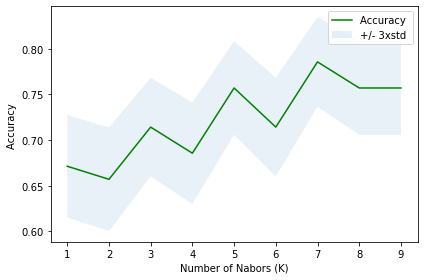

In [27]:
figknn = plt.figure(2)
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

# Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [29]:
loanTree = DecisionTreeClassifier(criterion="entropy")
loanTree.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy')

In [30]:
predTree = loanTree.predict(x_test)
print (predTree [0:5])
print (y_test [0:5])
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
DecisionTrees's Accuracy:  0.7


In [31]:
!pip install graphviz
!pip install pydotplus

In [32]:
from six import StringIO
import pydotplus
import matplotlib.image as mpimg
%matplotlib inline

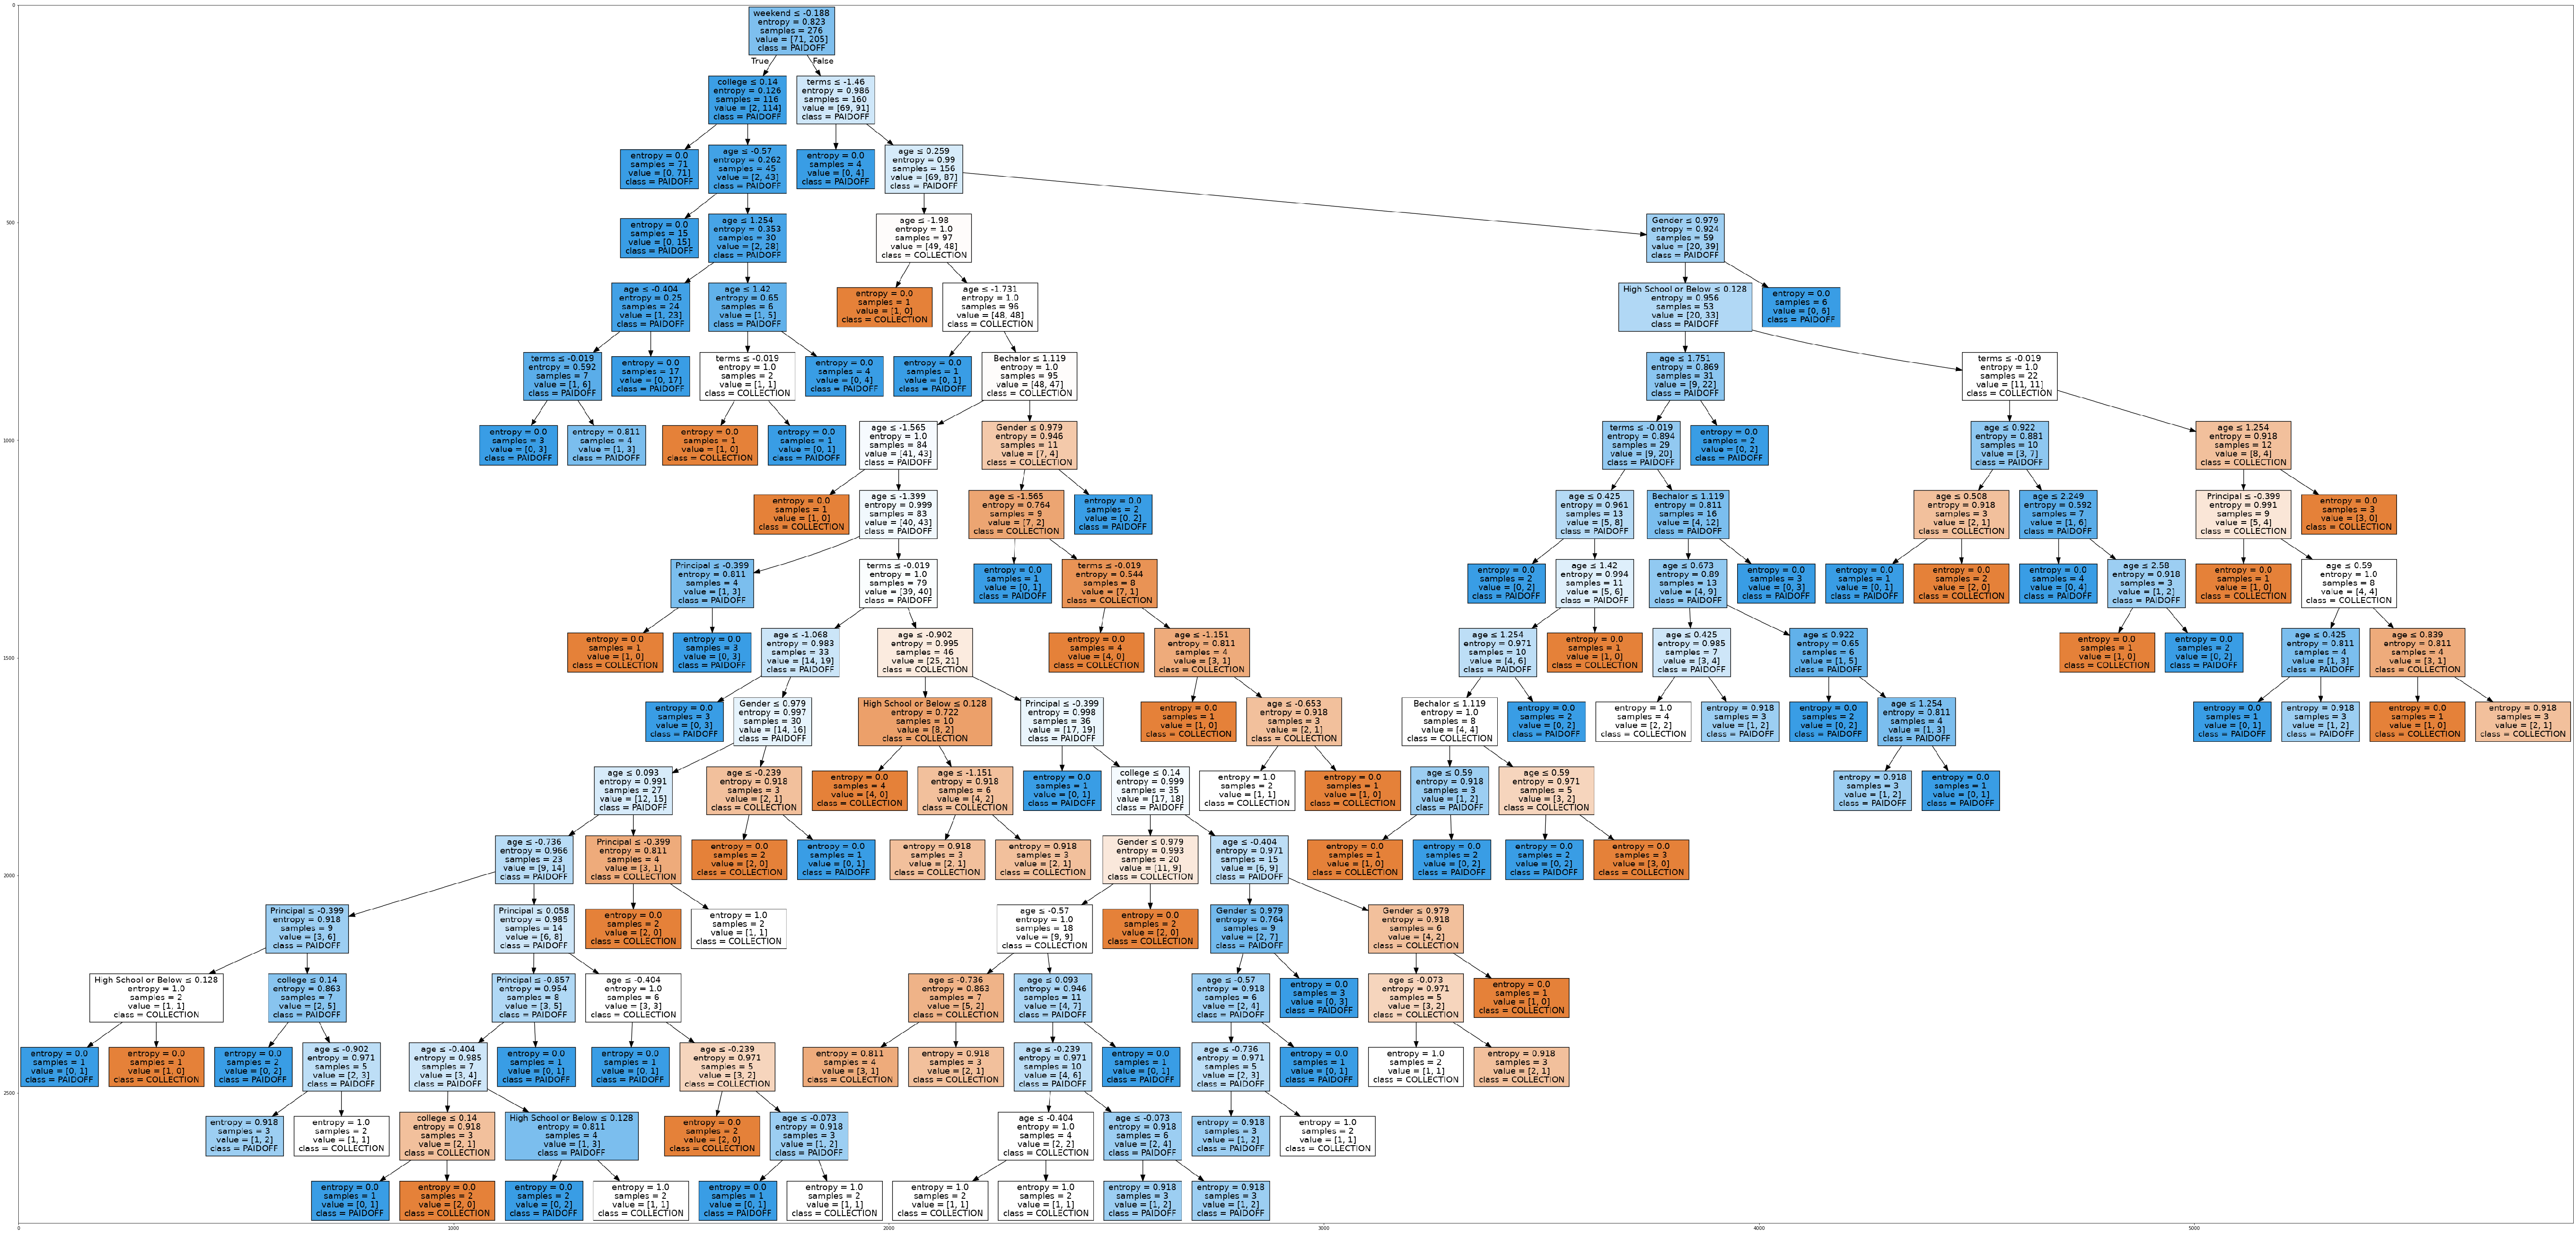

In [33]:
dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature.columns
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

In [34]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(x_train, y_train)

SVC(kernel='linear')

In [35]:
yhatsvm = clf.predict(x_test)
yhatsvm [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [36]:
jaccard_score(y_test, yhatsvm, pos_label='PAIDOFF')

0.7857142857142857

# Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [38]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(x_train,y_train)


In [39]:
yhat = LR.predict(x_test)
yhat_prob = LR.predict_proba(x_test)

In [40]:
jaccard_score(y_test, yhat, pos_label='PAIDOFF')

0.6764705882352942

# Model Evaluation

In [41]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [42]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-01-26 19:45:30--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-01-26 19:45:31 (99.3 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Test set for evaluation 

In [43]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30       9/8/2016   
1           5             5     PAIDOFF        300      7       9/9/2016   
2          21            21     PAIDOFF       1000     30      9/10/2016   
3          24            24     PAIDOFF       1000     30      9/10/2016   
4          35            35     PAIDOFF        800     15      9/11/2016   

    due_date  age             education  Gender  
0  10/7/2016   50              Bechalor  female  
1  9/15/2016   35       Master or Above    male  
2  10/9/2016   43  High School or Below  female  
3  10/9/2016   26               college    male  
4  9/25/2016   29              Bechalor    male

In [44]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_X = test_Feature
test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_y = test_df['loan_status'].values

In [45]:
knn = neigh.predict(test_X)
jsm_knn = jaccard_score(test_y, knn, pos_label='PAIDOFF')
f1s_knn = f1_score(test_y, knn, average='weighted')
print("KNN Jaccard:" , jsm_knn,"KNN F1-score:" , f1s_knn)

KNN Jaccard: 0.6862745098039216 KNN F1-score: 0.6736355806123249


In [46]:
Dtree = loanTree.predict(test_X)
jsm_tree = jaccard_score(test_y, Dtree, pos_label='PAIDOFF')
f1s_tree = f1_score(test_y, Dtree, average='weighted')
print("Decision tree Jaccard:" , jsm_tree,"Decision tree F1-score:" , f1s_tree)

Decision tree Jaccard: 0.6808510638297872 Decision tree F1-score: 0.7252534070517485


In [47]:
svm = clf.predict(test_X)
jsm_svm = jaccard_score(test_y, svm, pos_label='PAIDOFF')
f1s_svm = f1_score(test_y, svm, average='weighted')
print("SVM Jaccard:" , jsm_svm,"SVM F1-score:" , f1s_svm)

SVM Jaccard: 0.7407407407407407 SVM F1-score: 0.6304176516942475


In [48]:
LogReg = LR.predict(test_X)
LogReg_proba=LR.predict_proba(test_X)
jsm_LogReg = jaccard_score(test_y, LogReg, pos_label='PAIDOFF')
f1s_LogReg = f1_score(test_y, LogReg, average='weighted')
llLogReg=log_loss(test_y, LogReg_proba)
print("LR Jaccard:" , jsm_LogReg,"LogReg F1-score:" , f1s_LogReg,"LogReg LogLoss:",llLogReg)

LR Jaccard: 0.7358490566037735 LogReg F1-score: 0.6604267310789049 LogReg LogLoss: 0.5672153379912981


# Accuracy Report

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                |  0.686  |   0.674  | NA      |
| Decision Tree      |  0.680  |   0.725  | NA      |
| SVM                |  0.741  |   0.630  | NA      |
| LogisticRegression |  0.736  |   0.660  | 0.567   |